# MODELOS DE REDES PARA DENGUE BARRANCABERMEJA

### Cargue de librerias requeridas

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from pandas import concat
from pandas import read_csv
from pandas import DataFrame
import tensorflow as tf
from tensorflow import keras
import os
import datetime
import IPython
import IPython.display
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Flatten, LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Input, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib as mpl
%matplotlib inline
from scipy.stats import randint as sp_randint
np.random.seed(123) # for reproducibility
import warnings
warnings.filterwarnings('ignore')

### Cargar la base de datos

In [2]:
datos = read_csv('Barrancabermeja_Lags.csv', encoding='latin-1', sep=";")

# Se eliminan las columnas de las variables que No se van a utilizar
datos = datos.drop(['Municipio', 'Año', 'Semana_Epi',
       'Temp_Seca_Max_Dia_Prom', 'Temp_Seca_Max_Dia_Prom_1',
       'Temp_Seca_Max_Dia_Prom_2', 'Temp_Seca_Max_Dia_Prom_3',
       'Temp_Seca_Max_Dia_Prom_4', 'Temp_Seca_Max_Dia_Prom_5',
       'Temp_Seca_Max_Dia_Prom_6', 'Temp_Seca_Max_Sem', 'Temp_Seca_Max_Sem_1',
       'Temp_Seca_Max_Sem_2', 'Temp_Seca_Max_Sem_3', 'Temp_Seca_Max_Sem_4',
       'Temp_Seca_Max_Sem_5', 'Temp_Seca_Max_Sem_6', 'Temp_Seca_Min_Dia_Prom',
       'Temp_Seca_Min_Dia_Prom_1', 'Temp_Seca_Min_Dia_Prom_4',
       'Temp_Seca_Min_Dia_Prom_5', 'Temp_Seca_Min_Sem', 'Temp_Seca_Min_Sem_1', 'Temp_Seca_Min_Sem_2',
       'Temp_Seca_Min_Sem_3', 'Temp_Seca_Min_Sem_4', 'Temp_Seca_Min_Sem_5',
       'Temp_Seca_Min_Sem_6', 'Prom_Dia_Preci', 'Prom_Dia_Preci_1',
       'Prom_Dia_Preci_2', 'Prom_Dia_Preci_3', 'Prom_Dia_Preci_4',
       'Prom_Dia_Preci_5', 'Prom_Dia_Preci_6', 'Total_Preci_Sem',
       'Total_Preci_Sem_1', 'Total_Preci_Sem_2', 'Total_Preci_Sem_3',
       'Total_Preci_Sem_4', 'Total_Preci_Sem_5', 'Total_Preci_Sem_6',
       'Temp_Max_Dia_Prom', 'Temp_Max_Dia_Prom_1', 'Temp_Max_Dia_Prom_2',
       'Temp_Max_Dia_Prom_3', 'Temp_Max_Dia_Prom_4', 'Temp_Max_Dia_Prom_5',
       'Temp_Max_Dia_Prom_6', 'Temp_Max_Sem', 'Temp_Max_Sem_1',
       'Temp_Max_Sem_2', 'Temp_Max_Sem_3', 'Temp_Max_Sem_4', 'Temp_Max_Sem_5',
       'Temp_Max_Sem_6', 'Temp_Min_Dia_Prom', 'Temp_Min_Dia_Prom_1',
       'Temp_Min_Dia_Prom_2', 'Temp_Min_Dia_Prom_3', 'Temp_Min_Dia_Prom_4',
       'Temp_Min_Dia_Prom_5', 'Temp_Min_Dia_Prom_6', 'Temp_Min_Sem',
       'Temp_Min_Sem_1', 'Temp_Min_Sem_2', 'Temp_Min_Sem_3', 'Temp_Min_Sem_4',
       'Temp_Min_Sem_5', 'Temp_Min_Sem_6', 'Hum_Rel_Max', 'Hum_Rel_Max_1',
       'Hum_Rel_Max_2', 'Hum_Rel_Max_3', 'Hum_Rel_Max_4', 'Hum_Rel_Max_5',
       'Hum_Rel_Max_6','Hum_Rel_Min_1', 'Hum_Rel_Min_2',
       'Hum_Rel_Min_3', 'Hum_Rel_Min_5','Temp_Seca_Min_Dia_Prom_3', 'Temp_Seca_Min_Dia_Prom_6'],axis=1)
datos.columns

Index(['Casos_Dengue', 'Temp_Seca_Min_Dia_Prom_2', 'Hum_Rel_Min',
       'Hum_Rel_Min_4', 'Hum_Rel_Min_6'],
      dtype='object')

In [3]:
#Se verifican datos nulos o faltantes
datos.isnull().sum()

Casos_Dengue                 0
Temp_Seca_Min_Dia_Prom_2     0
Hum_Rel_Min                 28
Hum_Rel_Min_4               28
Hum_Rel_Min_6               28
dtype: int64

In [4]:
#Se realiza la imputación de los datos
knnImputer = KNNImputer (missing_values=np.nan, n_neighbors=2, 
                         weights="uniform", metric="nan_euclidean")
# Ajustamos el modelo e imputamos los missing values
knnImputer.fit(datos[['Hum_Rel_Min']])
datos['Hum_Rel_Min'] = knnImputer.transform(datos[['Hum_Rel_Min']]).ravel()
knnImputer.fit(datos[['Hum_Rel_Min_4']])
datos['Hum_Rel_Min_4'] = knnImputer.transform(datos[['Hum_Rel_Min_4']]).ravel()
knnImputer.fit(datos[['Hum_Rel_Min_6']])
datos['Hum_Rel_Min_6'] = knnImputer.transform(datos[['Hum_Rel_Min_6']]).ravel()

datos.shape

(624, 5)

### División de los datos en set de entrenamiento y prueba

In [5]:
train_size = int(len(datos) * 0.7)
test_size = len(datos) - train_size
train, test = datos.iloc[0:train_size], datos.iloc[train_size:len(datos)]
print(len(train), len(test))

436 188


In [6]:
f_columns = ['Temp_Seca_Min_Dia_Prom_2','Hum_Rel_Min', 'Hum_Rel_Min_4', 'Hum_Rel_Min_6']
f_transformer = MinMaxScaler(feature_range=(0, 1))
f_transformer = f_transformer.fit(train[f_columns].to_numpy())
train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())

In [7]:
dengue_transformer = MinMaxScaler(feature_range=(0, 1))
dengue_transformer = dengue_transformer.fit(train[['Casos_Dengue']])
train['Casos_Dengue'] = dengue_transformer.transform(train[['Casos_Dengue']])
test['Casos_Dengue'] = dengue_transformer.transform(test[['Casos_Dengue']])

In [8]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# MODELO LSTM

In [9]:
# Creación de X_train, y_train, X_test y y_test Para el modelo LSTM

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_LSTM, y_train_LSTM = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_LSTM, y_test_LSTM = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_LSTM.shape, y_train_LSTM.shape, X_test_LSTM.shape, y_test_LSTM.shape )

(429, 7, 5) (429,) (181, 7, 5) (181,)


### Construcción, Compilación y entrenamiento del modelo LSTM

In [10]:
Barr_LSTM_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_LSTM_model_1.add(keras.layers.InputLayer(input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_LSTM_model_1.add(keras.layers.LSTM(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Barr_LSTM_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Barr_LSTM_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_LSTM_model_1.h5'
checkpoint_LSTM = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_LSTM = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_LSTM = Barr_LSTM_model_1.fit(X_train_LSTM,y_train_LSTM, validation_data=(X_test_LSTM,y_test_LSTM), 
                                     verbose=2, epochs=100, callbacks=[monitor_LSTM, checkpoint_LSTM])
Barr_LSTM_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 8s - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0204 - val_mse: 0.0204 - 8s/epoch - 571ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0159 - val_mse: 0.0159 - 388ms/epoch - 28ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0109 - val_mse: 0.0109 - 394ms/epoch - 28ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0122 - val_mse: 0.0122 - 369ms/epoch - 26ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0077 - val_mse: 0.0077 - 413ms/epoch - 29ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0112 - val_mse: 0.0112 - 353ms/epoch - 25ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0093 - val_mse: 0.0093 - 365ms/epoch - 26ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0241 - mse: 0.0241 - val_loss: 0.0051 - val_mse: 0.0051 - 400ms/epoch - 29ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0238 - mse: 0.0238 - val_loss: 0.0054 - val_mse: 

# MODELO CNN

In [11]:
# Creación de X_train, y_train, X_test y y_test Para el modelo CNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_CNN, y_train_CNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_CNN, y_test_CNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_CNN.shape, y_train_CNN.shape, X_test_CNN.shape, y_test_CNN.shape )

(429, 7, 5) (429,) (181, 7, 5) (181,)


### Construcción, Compilación y entrenamiento del modelo CNN

In [12]:
Barr_CNN_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_CNN_model_1.add(keras.layers.InputLayer(input_shape=(X_train_CNN.shape[1], X_train_CNN.shape[2])))
     
#CAPAS INTERMEDIAS
Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Barr_CNN_model_1.add(keras.layers.Conv1D(80, kernel_size=2, strides=1, activation='linear', padding='same'))
Barr_CNN_model_1.add(keras.layers.MaxPooling1D(pool_size=2, padding='same'))

Barr_CNN_model_1.add(Dropout(0.5))
Barr_CNN_model_1.add(Flatten())
    
Barr_CNN_model_1.add(keras.layers.Dense(units=256, activation='linear'))
Barr_CNN_model_1.add(Dropout(0.5)) 

#CAPA DE SALIDA                 
Barr_CNN_model_1.add(Dense(1))

#COMPILACIÓN DEL MODELO
Barr_CNN_model_1.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mse'])

#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_CNN_model_1.h5'
checkpoint_CNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_CNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')

#ENTRENAMIENTO DEL MODELO
history_CNN = Barr_CNN_model_1.fit(X_train_CNN,y_train_CNN, validation_data=(X_test_CNN,y_test_CNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_CNN, checkpoint_CNN])
Barr_CNN_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 1s - loss: 0.0907 - mse: 0.0907 - val_loss: 0.0089 - val_mse: 0.0089 - 1s/epoch - 88ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0041 - val_mse: 0.0041 - 141ms/epoch - 10ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0252 - mse: 0.0252 - val_loss: 0.0095 - val_mse: 0.0095 - 118ms/epoch - 8ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0229 - mse: 0.0229 - val_loss: 0.0036 - val_mse: 0.0036 - 148ms/epoch - 11ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0048 - val_mse: 0.0048 - 103ms/epoch - 7ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0173 - mse: 0.0173 - val_loss: 0.0168 - val_mse: 0.0168 - 100ms/epoch - 7ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0037 - val_mse: 0.0037 - 98ms/epoch - 7ms/step


# MODELO RNN

In [13]:
# Creación de X_train, y_train, X_test y y_test Para el modelo RNN

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_RNN, y_train_RNN = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_RNN, y_test_RNN = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_RNN.shape, y_train_RNN.shape, X_test_RNN.shape, y_test_RNN.shape )

(429, 7, 5) (429,) (181, 7, 5) (181,)


### Construcción, Compilación y entrenamiento del modelo RNN

In [14]:
Barr_RNN_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_RNN_model_1.add(keras.layers.InputLayer(input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_RNN_model_1.add(keras.layers.SimpleRNN(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Barr_RNN_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Barr_RNN_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_RNN_model_1.h5'
checkpoint_RNN = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_RNN = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_RNN = Barr_RNN_model_1.fit(X_train_RNN,y_train_RNN, validation_data=(X_test_RNN,y_test_RNN), 
                                     verbose=2, epochs=100, callbacks=[monitor_RNN, checkpoint_RNN])
Barr_RNN_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 4s - loss: 0.0630 - mse: 0.0630 - val_loss: 0.0095 - val_mse: 0.0095 - 4s/epoch - 278ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0048 - val_mse: 0.0048 - 229ms/epoch - 16ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0105 - val_mse: 0.0105 - 193ms/epoch - 14ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0056 - val_mse: 0.0056 - 176ms/epoch - 13ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0244 - mse: 0.0244 - val_loss: 0.0155 - val_mse: 0.0155 - 169ms/epoch - 12ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0308 - mse: 0.0308 - val_loss: 0.0099 - val_mse: 0.0099 - 166ms/epoch - 12ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0058 - val_mse: 0.0058 - 199ms/epoch - 14ms/step


# MODELO GRU

In [15]:
# Creación de X_train, y_train, X_test y y_test Para el modelo GRU

time_steps = 7

# remodelar a [muestras, pasos_de_tiempo, n_características]
X_train_GRU, y_train_GRU = create_dataset(train, train.Casos_Dengue, time_steps)
X_test_GRU, y_test_GRU = create_dataset(test, test.Casos_Dengue, time_steps)
print(X_train_GRU.shape, y_train_GRU.shape, X_test_GRU.shape, y_test_GRU.shape )

(429, 7, 5) (429,) (181, 7, 5) (181,)


### Construcción, Compilación y entrenamiento del modelo GRU

In [16]:
Barr_GRU_model_1 = keras.Sequential()
    
# CAPA DE ENTRADA
Barr_GRU_model_1.add(keras.layers.InputLayer(input_shape=(X_train_GRU.shape[1], X_train_GRU.shape[2])))
    
    
#CAPAS INTERMEDIAS

Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))

Barr_GRU_model_1.add(keras.layers.GRU(units=100,
                            activation="tanh",
                            #return_sequences = True,
                            dropout= 0.5,
                            kernel_initializer="uniform"))
        
#CAPA DE SALIDA
Barr_GRU_model_1.add(keras.layers.Dense(1, activation="linear"))
    

#COMPILACIÓN DEL MODELO
Barr_GRU_model_1.compile(optimizer="adam", loss = 'mse', metrics = ['mse'])


#Se utiliza la devolución de llamada ModelCheckpoint para guardar puntos de control con regularidad 
#y la EarlyStopping para interrumpir el entrenamiento cuando la pérdida de validación ya no mejore.
model_filepath = 'Barr_GRU_model_1.h5'
checkpoint_GRU = ModelCheckpoint(model_filepath, monitor = 'val_loss', verbose=0, save_best_only = True, mode='min')
monitor_GRU = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto')


#ENTRENAMIENTO DEL MODELO
history_GRU = Barr_GRU_model_1.fit(X_train_GRU,y_train_GRU, validation_data=(X_test_GRU,y_test_GRU), 
                                     verbose=2, epochs=100, callbacks=[monitor_GRU, checkpoint_GRU])
Barr_GRU_model_1.load_weights(model_filepath)

Epoch 1/100
14/14 - 9s - loss: 0.0558 - mse: 0.0558 - val_loss: 0.0128 - val_mse: 0.0128 - 9s/epoch - 655ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0304 - mse: 0.0304 - val_loss: 0.0176 - val_mse: 0.0176 - 374ms/epoch - 27ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0305 - mse: 0.0305 - val_loss: 0.0106 - val_mse: 0.0106 - 429ms/epoch - 31ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0264 - mse: 0.0264 - val_loss: 0.0152 - val_mse: 0.0152 - 354ms/epoch - 25ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0106 - val_mse: 0.0106 - 381ms/epoch - 27ms/step
Epoch 6/100
14/14 - 0s - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0078 - val_mse: 0.0078 - 446ms/epoch - 32ms/step
Epoch 7/100
14/14 - 0s - loss: 0.0246 - mse: 0.0246 - val_loss: 0.0090 - val_mse: 0.0090 - 371ms/epoch - 27ms/step
Epoch 8/100
14/14 - 0s - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0050 - val_mse: 0.0050 - 416ms/epoch - 30ms/step
Epoch 9/100
14/14 - 0s - loss: 0.0228 - mse: 0.0228 - val_loss: 0.0056 - val_mse: 

### Graficas de función de pérdida & RMSE

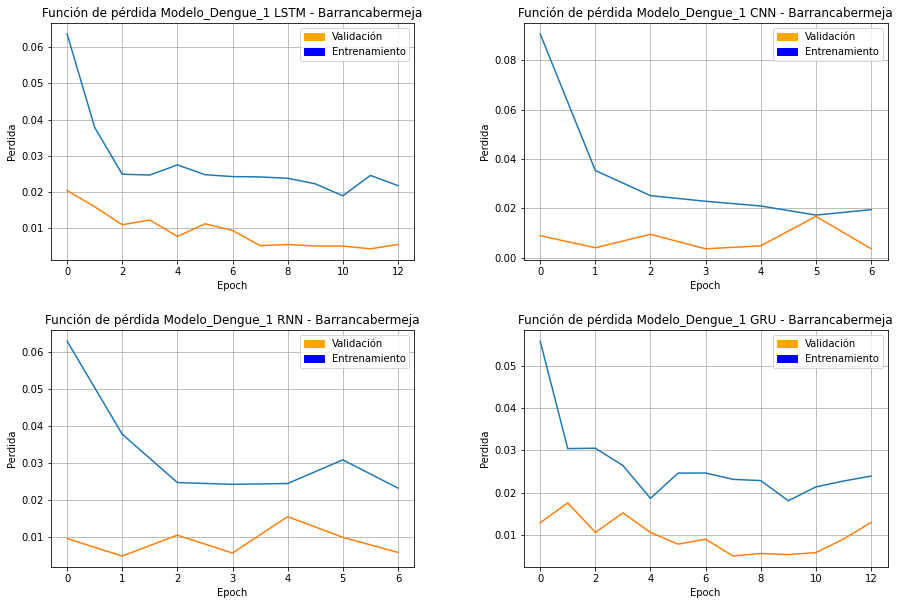

In [17]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 LSTM - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

plt.subplot(2, 2, 2)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 CNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_CNN.history['loss'])
plt.plot(history_CNN.history['val_loss'])

plt.subplot(2, 2, 3)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 RNN - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])

plt.subplot(2, 2, 4)
orange_patch = mpatches.Patch(color='orange', label='Validación')
blue_patch = mpatches.Patch(color='blue', label='Entrenamiento')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Función de pérdida Modelo_Dengue_1 GRU - Barrancabermeja')
plt.xlabel("Epoch")
plt.ylabel("Perdida")
plt.grid(True)
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])

plt.show()

# Gráficas de dispersión

6/6 [==============================] - 2s 14ms/step


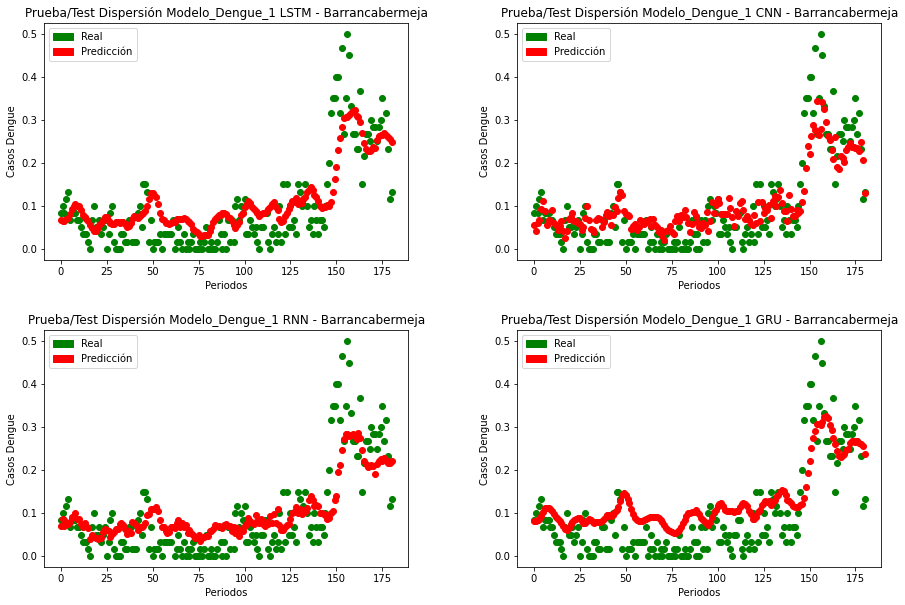

In [18]:
results_LSTM =Barr_LSTM_model_1.predict(X_test_LSTM)
results_CNN =Barr_CNN_model_1.predict(X_test_CNN)
results_RNN =Barr_RNN_model_1.predict(X_test_RNN)
results_GRU =Barr_GRU_model_1.predict(X_test_GRU)

plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 LSTM - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_LSTM)),y_test_LSTM,c='g')
plt.scatter(range(len(results_LSTM)),results_LSTM,c='r')

plt.subplot(2, 2, 2)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 CNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_CNN)),y_test_CNN,c='g')
plt.scatter(range(len(results_CNN)),results_CNN,c='r')

plt.subplot(2, 2, 3)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 RNN - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_RNN)),y_test_RNN,c='g')
plt.scatter(range(len(results_RNN)),results_RNN,c='r')

plt.subplot(2, 2, 4)
green_patch = mpatches.Patch(color='green', label='Real')
red_patch = mpatches.Patch(color='red', label='Predicción')
plt.legend(handles=[green_patch, red_patch])
plt.title('Prueba/Test Dispersión Modelo_Dengue_1 GRU - Barrancabermeja')
plt.xlabel("Periodos")
plt.ylabel("Casos Dengue")
plt.scatter(range(len(y_test_GRU)),y_test_GRU,c='g')
plt.scatter(range(len(results_GRU)),results_GRU,c='r')

plt.show()

In [19]:
y_pred_LSTM = Barr_LSTM_model_1.predict(X_test_LSTM)
y_pred_CNN = Barr_CNN_model_1.predict(X_test_CNN)
y_pred_RNN = Barr_RNN_model_1.predict(X_test_RNN)
y_pred_GRU = Barr_GRU_model_1.predict(X_test_GRU)

y_train_inv_LSTM = dengue_transformer.inverse_transform(y_train_LSTM.reshape(1, -1))
y_train_inv_CNN = dengue_transformer.inverse_transform(y_train_CNN.reshape(1, -1))
y_train_inv_RNN = dengue_transformer.inverse_transform(y_train_RNN.reshape(1, -1))
y_train_inv_GRU = dengue_transformer.inverse_transform(y_train_GRU.reshape(1, -1))

y_test_inv_LSTM = dengue_transformer.inverse_transform(y_test_LSTM.reshape(1, -1))
y_test_inv_CNN = dengue_transformer.inverse_transform(y_test_CNN.reshape(1, -1))
y_test_inv_RNN = dengue_transformer.inverse_transform(y_test_RNN.reshape(1, -1))
y_test_inv_GRU = dengue_transformer.inverse_transform(y_test_GRU.reshape(1, -1))

y_pred_inv_LSTM = dengue_transformer.inverse_transform(y_pred_LSTM)
y_pred_inv_CNN = dengue_transformer.inverse_transform(y_pred_CNN)
y_pred_inv_RNN = dengue_transformer.inverse_transform(y_pred_RNN)
y_pred_inv_GRU = dengue_transformer.inverse_transform(y_pred_GRU)

6/6 [==============================] - 0s 11ms/step


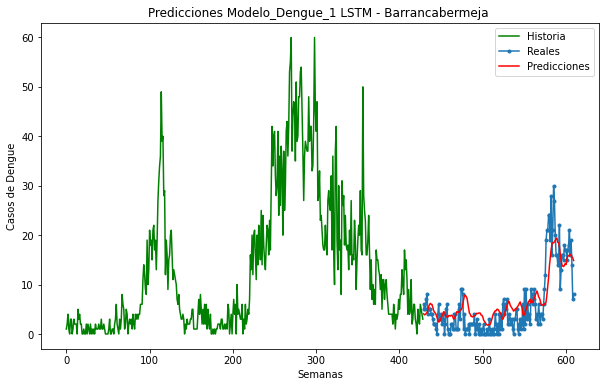

In [20]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_LSTM)), y_train_inv_LSTM.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_test_inv_LSTM.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_LSTM), len(y_train_LSTM) + len(y_test_LSTM)), y_pred_inv_LSTM.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 LSTM - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

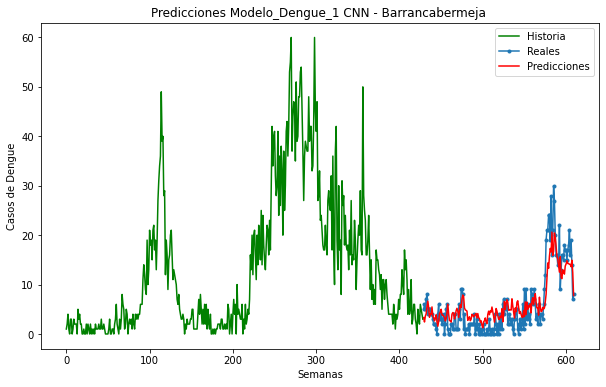

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_CNN)), y_train_inv_CNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_test_inv_CNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_CNN), len(y_train_CNN) + len(y_test_CNN)), y_pred_inv_CNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 CNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

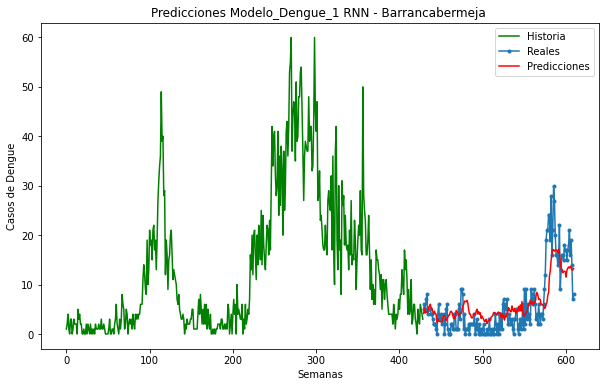

In [22]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_RNN)), y_train_inv_RNN.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_test_inv_RNN.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_RNN), len(y_train_RNN) + len(y_test_RNN)), y_pred_inv_RNN.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 RNN - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

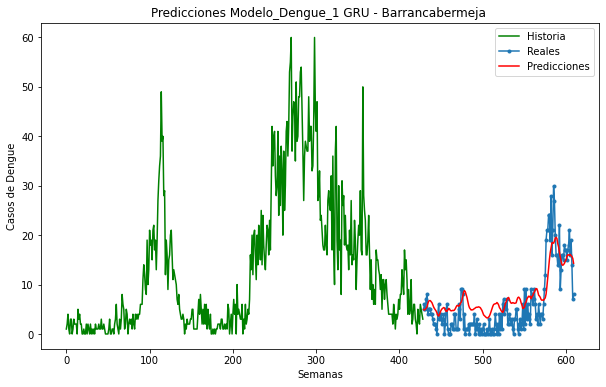

In [23]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0, len(y_train_GRU)), y_train_inv_GRU.flatten(), 'g', label="Historia")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_test_inv_GRU.flatten(), marker='.', label="Reales")
plt.plot(np.arange(len(y_train_GRU), len(y_train_GRU) + len(y_test_GRU)), y_pred_inv_GRU.flatten(), 'r', label="Predicciones")
plt.title('Predicciones Modelo_Dengue_1 GRU - Barrancabermeja ')
plt.ylabel('Casos de Dengue')
plt.xlabel('Semanas')
plt.legend()
plt.show();

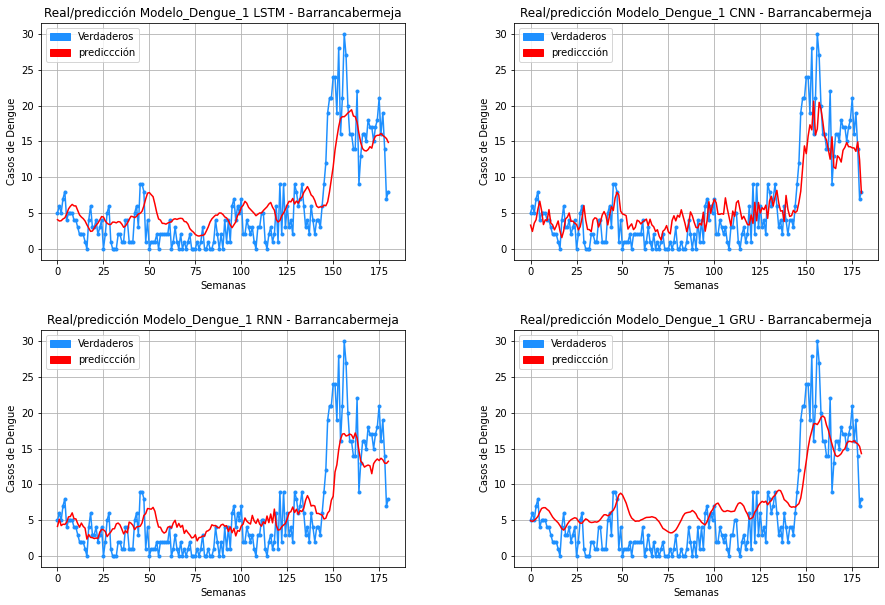

In [24]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(2, 2, 1)
plt.title('Real/predicción Modelo_Dengue_1 LSTM - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_LSTM.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_LSTM.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.title('Real/predicción Modelo_Dengue_1 CNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_CNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_CNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.title('Real/predicción Modelo_Dengue_1 RNN - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_RNN.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_RNN.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.title('Real/predicción Modelo_Dengue_1 GRU - Barrancabermeja' )
green_patch = mpatches.Patch(color='dodgerblue', label="Verdaderos")
red_patch = mpatches.Patch(color='red', label="prediccción")
plt.legend(handles=[green_patch, red_patch])
plt.plot(y_test_inv_GRU.flatten(), marker='.', color= 'dodgerblue', label="Verdaderos")
plt.plot(y_pred_inv_GRU.flatten(), color= 'red', label="prediccción")
plt.xlabel("Semanas")
plt.ylabel("Casos de Dengue")
plt.grid(True)

plt.show()

In [25]:
score_LSTM = np.sqrt(metrics.mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
score_CNN = np.sqrt(metrics.mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
score_RNN = np.sqrt(metrics.mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
score_GRU = np.sqrt(metrics.mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

print("RMSE Modelo LSTM Dengue Barranca : {}".format(score_LSTM))
print("RMSE Modelo CNN Dengue Barranca  : {}".format(score_CNN))
print("RMSE Modelo RNN Dengue Barranca  : {}".format(score_RNN))
print("RMSE Modelo GRU Dengue Barranca  : {}".format(score_GRU))

RMSE Modelo LSTM Dengue Barranca : 3.9136173769742624
RMSE Modelo CNN Dengue Barranca  : 3.615656707148274
RMSE Modelo RNN Dengue Barranca  : 4.153320423792997
RMSE Modelo GRU Dengue Barranca  : 4.2336451276180345


In [26]:
print("MSE Modelo LSTM Dengue Barranca  = ", mean_squared_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MSE Modelo CNN Dengue Barranca   = ", mean_squared_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MSE Modelo RNN Dengue Barranca   = ", mean_squared_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MSE Modelo GRU Dengue Barranca   = ", mean_squared_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MSE Modelo LSTM Dengue Barranca  =  15.316400973354904
MSE Modelo CNN Dengue Barranca   =  13.072973423946301
MSE Modelo RNN Dengue Barranca   =  17.25007054269604
MSE Modelo GRU Dengue Barranca   =  17.923751066603923


In [27]:
print("MAE Modelo LSTM Dengue Barranca = ", mean_absolute_error(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("MAE Modelo CNN Dengue Barranca  = ", mean_absolute_error(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("MAE Modelo RNN Dengue Barranca  = ", mean_absolute_error(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("MAE Modelo GRU Dengue Barranca  = ", mean_absolute_error(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

MAE Modelo LSTM Dengue Barranca =  3.069943193572661
MAE Modelo CNN Dengue Barranca  =  2.8310313297240115
MAE Modelo RNN Dengue Barranca  =  3.1627440004717577
MAE Modelo GRU Dengue Barranca  =  3.5435405567864686


In [28]:
print("r2_score Modelo LSTM Dengue Barranca  = ", r2_score(y_test_inv_LSTM.flatten(), y_pred_inv_LSTM.flatten()))
print("r2_score Modelo CNN Dengue Barranca  = ", r2_score(y_test_inv_CNN.flatten(), y_pred_inv_CNN.flatten()))
print("r2_score Modelo RNN Dengue Barranca  = ", r2_score(y_test_inv_RNN.flatten(), y_pred_inv_RNN.flatten()))
print("r2_score Modelo GRU Dengue Barranca  = ", r2_score(y_test_inv_GRU.flatten(), y_pred_inv_GRU.flatten()))

r2_score Modelo LSTM Dengue Barranca  =  0.6486715713430955
r2_score Modelo CNN Dengue Barranca  =  0.7001314330371375
r2_score Modelo RNN Dengue Barranca  =  0.6043169548427749
r2_score Modelo GRU Dengue Barranca  =  0.58886403478061


In [29]:
print("explained_variance_score Modelo LSTM Dengue Barranca  = ", explained_variance_score(y_test_inv_LSTM.flatten(), 
                                                                                           y_pred_inv_LSTM.flatten()))
print("explained_variance_score Modelo CNN Dengue Barranca  = ", explained_variance_score(y_test_inv_CNN.flatten(), 
                                                                                           y_pred_inv_CNN.flatten()))
print("explained_variance_score Modelo RNN Dengue Barranca  = ", explained_variance_score(y_test_inv_RNN.flatten(), 
                                                                                           y_pred_inv_RNN.flatten()))
print("explained_variance_score Modelo GRU Dengue Barranca  = ", explained_variance_score(y_test_inv_GRU.flatten(), 
                                                                                           y_test_inv_GRU.flatten()))

explained_variance_score Modelo LSTM Dengue Barranca  =  0.6657829217988793
explained_variance_score Modelo CNN Dengue Barranca  =  0.7037370488621513
explained_variance_score Modelo RNN Dengue Barranca  =  0.6063844681486585
explained_variance_score Modelo GRU Dengue Barranca  =  1.0


### VISUALIZACIÓN DE LOS VALORES TESTEADOS VS LAS PREDICCIONES

In [30]:
#MODELO LSTM
resultados_LSTM = pd.DataFrame({ 'Actuales':y_test_inv_LSTM.flatten(), 'Predicciones': y_pred_inv_LSTM.flatten()})
resultados_LSTM['diferencia'] = resultados_LSTM['Predicciones'] - resultados_LSTM['Actuales']
print(resultados_LSTM.head(5))
print(resultados_LSTM.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      4.072323   -0.927677
1       6.0      3.880922   -2.119078
2       5.0      3.917502   -1.082498
3       7.0      4.168428   -2.831572
4       8.0      4.322204   -3.677796
     Actuales  Predicciones  diferencia
176      16.0     16.104977    0.104977
177      19.0     15.826323   -3.173677
178      14.0     15.633822    1.633822
179       7.0     15.391345    8.391345
180       8.0     14.854986    6.854986


In [31]:
#MODELO CNN
resultados_CNN = pd.DataFrame({ 'Actuales':y_test_inv_CNN.flatten(), 'Predicciones': y_pred_inv_CNN.flatten()})
resultados_CNN['diferencia'] = resultados_CNN['Predicciones'] - resultados_CNN['Actuales']
print(resultados_CNN.head(5))
print(resultados_CNN.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      3.302905   -1.697095
1       6.0      2.428192   -3.571808
2       5.0      3.577893   -1.422107
3       7.0      4.061787   -2.938213
4       8.0      5.570275   -2.429725
     Actuales  Predicciones  diferencia
176      16.0     14.085758   -1.914242
177      19.0     13.606868   -5.393132
178      14.0     14.926440    0.926440
179       7.0     12.412677    5.412677
180       8.0      7.786843   -0.213157


In [32]:
#MODELO RNN
resultados_RNN = pd.DataFrame({ 'Actuales':y_test_inv_RNN.flatten(), 'Predicciones': y_pred_inv_RNN.flatten()})
resultados_RNN['diferencia'] = resultados_RNN['Predicciones'] - resultados_RNN['Actuales']
print(resultados_RNN.head(5))
print(resultados_RNN.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      4.140625   -0.859375
1       6.0      5.142489   -0.857511
2       5.0      4.249732   -0.750268
3       7.0      4.448918   -2.551082
4       8.0      4.414185   -3.585815
     Actuales  Predicciones  diferencia
176      16.0     13.657613   -2.342387
177      19.0     13.441515   -5.558485
178      14.0     12.976653   -1.023347
179       7.0     12.938380    5.938380
180       8.0     13.236433    5.236433


In [33]:
#MODELO GRU
resultados_GRU = pd.DataFrame({ 'Actuales':y_test_inv_GRU.flatten(), 'Predicciones': y_pred_inv_GRU.flatten()})
resultados_GRU['diferencia'] = resultados_GRU['Predicciones'] - resultados_GRU['Actuales']
print(resultados_GRU.head(5))
print(resultados_GRU.tail(5))

   Actuales  Predicciones  diferencia
0       5.0      4.948883   -0.051117
1       6.0      4.829961   -1.170039
2       5.0      4.991319   -0.008681
3       7.0      5.218659   -1.781341
4       8.0      5.537426   -2.462574
     Actuales  Predicciones  diferencia
176      16.0     16.098587    0.098587
177      19.0     15.828538   -3.171462
178      14.0     15.673777    1.673777
179       7.0     15.312125    8.312125
180       8.0     14.308660    6.308660
